# 💵 How much better can we do with ARIMA?

Ah, you if remember from the previous try to run the holt-winters model on the stock data, we also did a **manual try** on the real world example for the RELIANCE data. Now, again we are going to do the same — but this time with a better approach ARIMA.

Let's get right into it, as there is *nothing new* to explain, we can code directly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (20, 10)

import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error

In [2]:
# period of analysis
end = datetime.now()
start = end - timedelta(days=365 * 5)

stock = "RELIANCE.NS"
data = web.DataReader(stock, 'yahoo', start, end)

Start: Year, Month, Day, Time
2017-08-13 19:30:36.337036


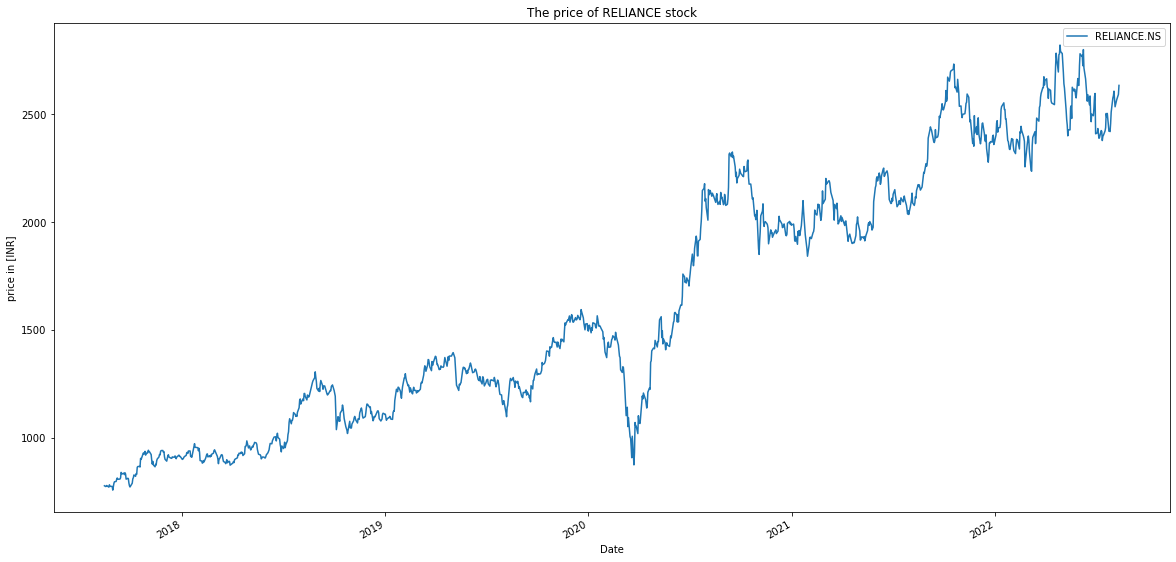

In [4]:
# nice looking timeseries (DataFrame to panda Series)
data = data.reset_index()
data = pd.Series(data.Close.values, data.Date)

print("Start: Year, Month, Day, Time")
print(str(start))
data.plot(label=stock);
plt.legend()
plt.ylabel('price in [INR]')

plt.title("The price of RELIANCE stock")
plt.show();

Please don't worry about the code above, it is just to fetch the RELIANCE data till now. Nothing else. 

In [6]:
# The train and test split
train_idx = data.iloc[:-31].index
test_idx = data.iloc[-31:].index

In [7]:
# Check the R2 and MAE
def get_metrics(true, forecast):
    print("MAPE:", round(mean_absolute_percentage_error(true, forecast) * 100, 4), "%")
    print("MAE:", mean_absolute_error(true, forecast))
    print("RMSE:", mean_squared_error(true, forecast, squared=False))
    print("R2:", r2_score(true, forecast))

## 🔫  Gun is loaded. Let's shoot. (Non violently; of course.)

#### 1️⃣ Simple model, initial parameters

In [10]:
initial_model = pm.auto_arima(data[train_idx], 
                             seasonal=True,
                             m=12,
                             stepwise=True,
                             trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=11773.220, Time=6.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=11779.792, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=11782.937, Time=1.97 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=11782.945, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=11780.391, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=11771.126, Time=7.86 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=11769.221, Time=3.51 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=11771.217, Time=5.81 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=11783.511, Time=1.53 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=11783.814, Time=1.29 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=11771.167, Time=3.92 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=11771.170, Time=3.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=11783.785, Time=0.86 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=11783.490, Time=2.08 sec
 ARIM